# Projections and cross-grammian for FEM solutions on the dyadic-subdivided unit square

In [ ]:
import numpy as np
import importlib
import dyadic_fem as df
import matplotlib.pyplot as plt
importlib.reload(df)
%matplotlib inline

### First we make our solution $u_h(x,y)$ for $h=2^{-\mathtt{fem-div}}$, and field $a(x,y)$
Again we solve the problem $-\nabla \cdot (a(x,y) \nabla u(x,y)) = f(x,y)$ using FEM. We then construct a basis of hat functions and sin functions on the grid of dyadic level $\mathtt{coarse\_div}$, both of which we also orthonormalise. Approximation in both the sin and hat functions should be the same as the bases span the same subspace of dyadic piece-wise linear functions

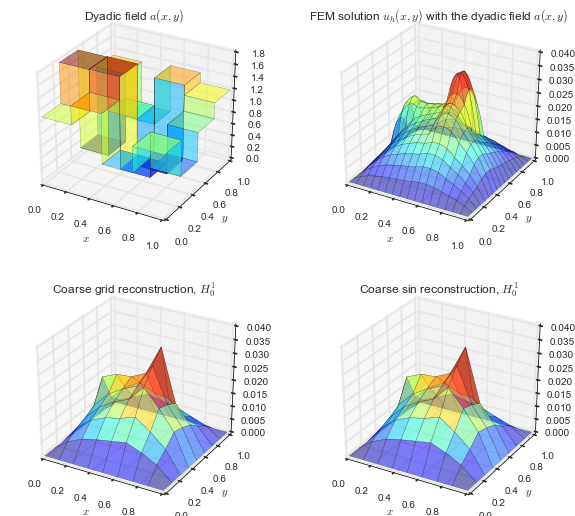

In [4]:
#importlib.reload(df)

field_div = 2
fem_div = 8
coarse_div = 3

# First we generate our solution
a = df.make_dyadic_random_field(div=field_div, a_bar=1.0, c=0.99, seed=3)
fem = df.DyadicFEMSolver(div=fem_div, rand_field=a, f=1.0)
fem.solve()

coarse_grid = 2**coarse_div - 1
# Now make our bases
hat_b = df.make_hat_basis(coarse_div, space='H1')
sin_b = df.make_sin_basis(coarse_div, N=coarse_grid, space='H1')

hat_b_ortho = hat_b.orthonormalise()
sin_b_ortho = sin_b.orthonormalise()

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(2, 2, 1, projection='3d')
a.plot(ax, title='Dyadic field $a(x,y)$')
ax = fig.add_subplot(2, 2, 2, projection='3d')
fem.u.plot(ax, title='FEM solution $u_h(x,y)$ with the dyadic field $a(x,y)$')
ax = fig.add_subplot(2, 2, 3, projection='3d')
hat_b.project(fem.u).plot(ax, title='Coarse grid reconstruction, $H^1_0$')
ax = fig.add_subplot(2, 2, 4, projection='3d')
sin_b.project(fem.u).plot(ax, title='Coarse sin reconstruction, $H^1_0$')

### We take average value around a point as our measurement, which has a representer of a simple indicator function around that point

n=49, m=225. Remember we require n <= m!


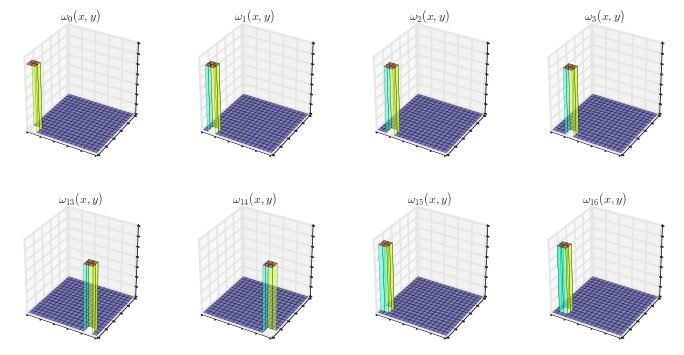

In [5]:
#importlib.reload(df)

# And now make our measurements
meas_div = 4
M_m = []
for i in range(2**meas_div-1):
    for j in range(2**meas_div-1):
        h = 2**(-meas_div)
        meas = df.DyadicPWConstant(div=meas_div)
        meas.values[i:i+2,j:j+2] = 1.0 / (4*h*h)
        
        M_m.append(meas)
W = df.Basis(M_m, 'H1')

# Remember we need n = len(basis) to be less than m = len(measurements)
print("n={0}, m={1}. Remember we require n <= m!".format(len(sin_b.vecs), len(M_m)))

c = np.zeros(len(M_m))
for meas in M_m:
    fem.u.dot(meas, 'H1')
    
show_n = 4
fig = plt.figure(figsize=(12, 6))
for i in range(show_n):
    ax = fig.add_subplot(2, show_n, i+1, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    W.vecs[i].plot(ax, title='$\omega_{{{0}}}(x,y)$'.format(i), show_axes_labels=False)

    ax = fig.add_subplot(2, show_n, i+1+show_n, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    W.vecs[i+13].plot(ax, title='$\omega_{{{0}}}(x,y)$'.format(i+13), show_axes_labels=False)
    
W_ortho = W.orthonormalise()

In [6]:
#importlib.reload(df)

# Ooops! I had the cross-grammian the wrong way around!
# e.g. G_hat = hat_b.cross_grammian(W)
# Should actually be this way around: G_hat = W.cross_grammian(hat_b)

print('Condition numbers')
for Phi in ('hat_b', 'sin_b', 'hat_b_ortho', 'sin_b_ortho'):
    for w in ('W', 'W_ortho'):
        G = eval(w).cross_grammian(eval(Phi))
        print(Phi + ' x\t' + w + '\t:\t {0}'.format(np.linalg.cond(G.T @ G)))


Condition numbers
hat_b x	W	:	 36.838431586653904
hat_b x	W_ortho	:	 11.283520691973877
sin_b x	W	:	 36.83843158665385
sin_b x	W_ortho	:	 11.283520691973877
hat_b_ortho x	W	:	 887.7055561585371
hat_b_ortho x	W_ortho	:	 271.8781501005534
sin_b_ortho x	W	:	 887.7055561585361
sin_b_ortho x	W_ortho	:	 271.87815010055317


Ok... condition numbers aren't too bad, let's solve the system and see what happens with our created projections
### Finally we do the full single space reconstruction
Here we have $W$ is the space of coarse grid measurements and $V_n$ is the complete basis of hat functions

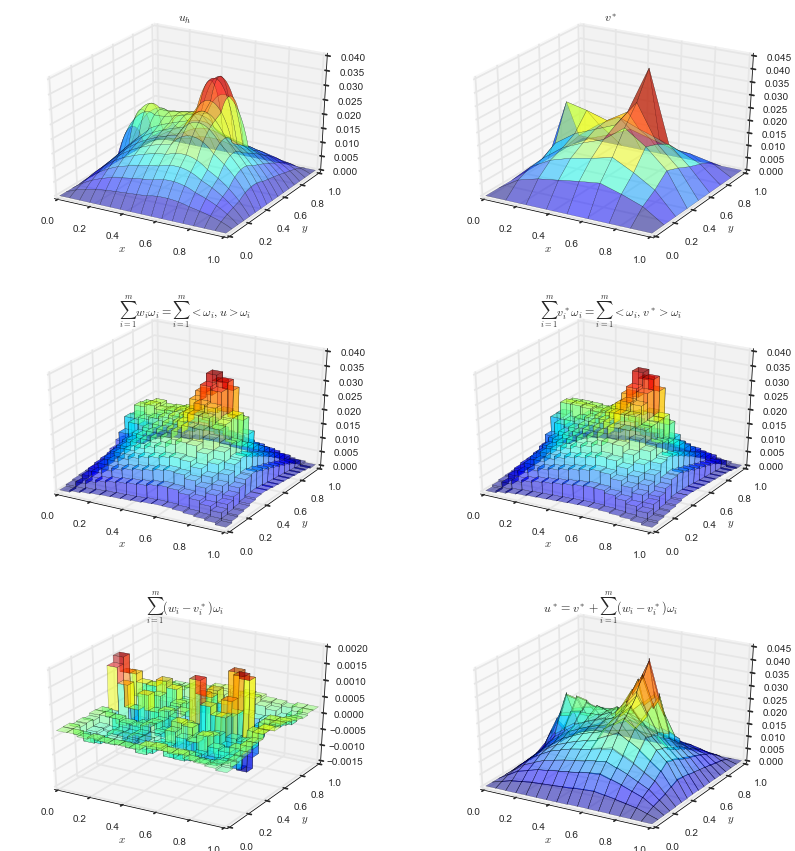

In [8]:
# Lets take the hat functions and the orthonormal basis for the measurements
G = W_ortho.cross_grammian(hat_b)
w = W_ortho.dot(fem.u)
c = np.linalg.solve(G.T @ G, G.T @ w)

v_star = hat_b.reconstruct(c)

u_star = v_star + W_ortho.reconstruct(w - W_ortho.dot(v_star))

%matplotlib inline
fig = plt.figure(figsize=(14, 15))
ax = fig.add_subplot(3, 2, 1, projection='3d')
fem.u.plot(ax, title='$u_h$')
ax = fig.add_subplot(3, 2, 2, projection='3d')
v_star.plot(ax, title='$v^*$')
ax = fig.add_subplot(3, 2, 3, projection='3d')
W_ortho.reconstruct(w).plot(ax, title='$\sum_{i=1}^m w_i \omega_i = \sum_{i=1}^m < \omega_i, u > \omega_i$')
ax = fig.add_subplot(3, 2, 4, projection='3d')
W_ortho.reconstruct(W_ortho.dot(v_star)).plot(ax, title='$\sum_{i=1}^m v^*_i \omega_i = \sum_{i=1}^m < \omega_i, v^* > \omega_i$')
ax = fig.add_subplot(3, 2, 5, projection='3d')
W_ortho.reconstruct(w - W_ortho.dot(v_star)).plot(ax, title='$\sum_{i=1}^m(w_i - v_i^*)\omega_i$')
ax = fig.add_subplot(3, 2, 6, projection='3d')
u_star.plot(ax, title='$u^* = v^* + \sum_{i=1}^m(w_i - v_i^*)\omega_i$')

### Lets try some random measurements and the hat functions...
So here $W$ is the space of dyadic-square averages (i.e. a collection of indicator functions), and $V_n$ the complete basis of hat functions on a coarse grid. Again recall that we want $\kappa(\mathbf{G}^T\mathbf{G}) < 100$...

In [ ]:
meas_div = 4
m = 2**(meas_div+2) # This is just an amount that relates to the grid size...
vn_div = 3

np.random.seed(5)
# W is our measurement space, of dimension m
W = df.make_random_local_integration_basis(m, div=meas_div, width=2, space='H1')
# V_n is the FEM solution approximation space, of dimension n (=2^vn_div * 2^vn_div)
V_n = df.make_hat_basis(vn_div, space='H1')
print('Dimensions of W = m = {0}, dimension of V_n = n = {1}'.format(m, V_n.n))

# This is the measurement vector
W_ortho = W.orthonormalise()
w = W_ortho.dot(fem.u)

u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n, w, disp_cond=True)

per_row = 6
show_n = min(12, m)
fig = plt.figure(figsize=(14, 2*np.ceil(show_n/per_row)))
for i in range(show_n):
    ax = fig.add_subplot(np.ceil(show_n/per_row), per_row, i+1, projection='3d')    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    W_ortho.vecs[i].plot(ax, title='$\omega_{{{0}}}(x,y)$'.format(i), show_axes_labels=False)
plt.show()

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1, projection='3d')
(W.reconstruct(np.ones(W.n))).plot(ax, title='Total measurement points')
plt.show()

%matplotlib inline
fig = plt.figure(figsize=(14, 15))
ax = fig.add_subplot(3, 2, 1, projection='3d')
fem.u.plot(ax, title='$u_h$')
ax = fig.add_subplot(3, 2, 2, projection='3d')
v_star.plot(ax, title='$v^*$')
ax = fig.add_subplot(3, 2, 3, projection='3d')
w_recon.plot(ax, title='$\sum_{i=1}^m w_i \omega_i = \sum_{i=1}^m < \omega_i, u > \omega_i$')
ax = fig.add_subplot(3, 2, 4, projection='3d')
v_proj.plot(ax, title='$\sum_{i=1}^m v^*_i \omega_i = \sum_{i=1}^m < \omega_i, v^* > \omega_i$')
ax = fig.add_subplot(3, 2, 5, projection='3d')
(w_recon - v_proj).plot(ax, title='$\sum_{i=1}^m(w_i - v_i^*)\omega_i$')
ax = fig.add_subplot(3, 2, 6, projection='3d')
u_star.plot(ax, title='$u^* = v^* + \sum_{i=1}^m(w_i - v_i^*)\omega_i$')

### Lets look at the convergence of the condition number as $m\to \infty$ for fixed $n$
We take $s$ different randomly generated measurement bases $W$, and $V_n$ is the complete space of coarse dyadic grid hat functions

Dimensions of W = m = 90, dimension of V_n = n = 49
Condition number of G.T * G = 2689.129720135885
Condition number of G.T * G = 17018.97867114858
Condition number of G.T * G = 204.1211765987384
Condition number of G.T * G = 912.1303063538949
Condition number of G.T * G = 400.7203331705639
Condition number of G.T * G = 41030.73124715816
Condition number of G.T * G = 5026.219678234862
Condition number of G.T * G = 1621.6620621763109
Condition number of G.T * G = 2380.4199361535448
Condition number of G.T * G = 945.2081586367764


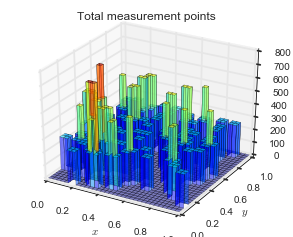

Dimensions of W = m = 128, dimension of V_n = n = 49
Condition number of G.T * G = 82.66163121658126
Condition number of G.T * G = 142.3948072915725
Condition number of G.T * G = 83.81762571261052
Condition number of G.T * G = 48.688453839494436
Condition number of G.T * G = 187.99480240557392
Condition number of G.T * G = 3180.0630388716686
Condition number of G.T * G = 47.177985357306135
Condition number of G.T * G = 51.74802262856777
Condition number of G.T * G = 144.73660015745668
Condition number of G.T * G = 35.20022859844537


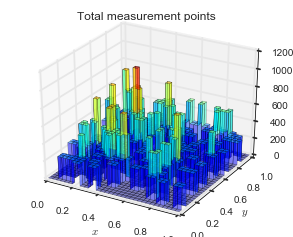

Dimensions of W = m = 181, dimension of V_n = n = 49
Condition number of G.T * G = 52.44776255963013
Condition number of G.T * G = 21.21000529740084
Condition number of G.T * G = 26.83427330184602
Condition number of G.T * G = 34.415968411703965
Condition number of G.T * G = 22.739227380228172
Condition number of G.T * G = 16.65629178360983
Condition number of G.T * G = 23.43602917062843
Condition number of G.T * G = 25.804546154283504
Condition number of G.T * G = 20.75099041274449
Condition number of G.T * G = 57.33572787478068


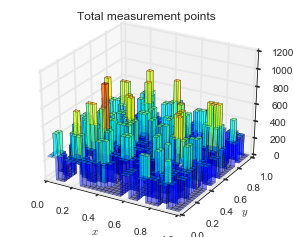

Dimensions of W = m = 256, dimension of V_n = n = 49
Condition number of G.T * G = 23.674523995165355
Condition number of G.T * G = 11.784707466766413
Condition number of G.T * G = 13.629423179361986
Condition number of G.T * G = 15.36558529549584
Condition number of G.T * G = 14.207296007276323
Condition number of G.T * G = 16.71970472477967
Condition number of G.T * G = 12.617636926021806
Condition number of G.T * G = 14.582971390802362
Condition number of G.T * G = 10.076023221843723
Condition number of G.T * G = 16.65204193881016


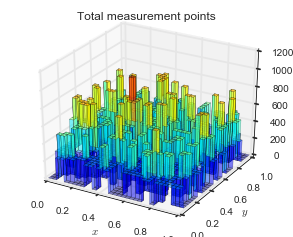

Dimensions of W = m = 362, dimension of V_n = n = 49
Condition number of G.T * G = 10.928393661426584
Condition number of G.T * G = 10.59284388824037
Condition number of G.T * G = 9.88249591910163
Condition number of G.T * G = 9.468426733361268
Condition number of G.T * G = 11.213389213124218
Condition number of G.T * G = 10.24658233971642
Condition number of G.T * G = 10.681816579688572
Condition number of G.T * G = 10.625627529380955
Condition number of G.T * G = 12.115869481461964
Condition number of G.T * G = 11.187773692167806


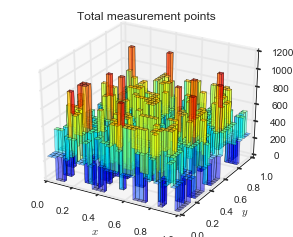

Dimensions of W = m = 512, dimension of V_n = n = 49
Condition number of G.T * G = 8.631821326095219
Condition number of G.T * G = 8.557600787888719
Condition number of G.T * G = 8.609742436732926
Condition number of G.T * G = 8.747400559808835
Condition number of G.T * G = 9.04985822076349
Condition number of G.T * G = 8.700719943456937
Condition number of G.T * G = 8.834218287807778
Condition number of G.T * G = 8.51780470121954
Condition number of G.T * G = 8.675925567156401
Condition number of G.T * G = 8.721785226092734


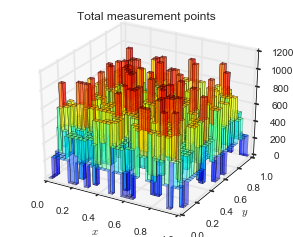

Dimensions of W = m = 724, dimension of V_n = n = 49
Condition number of G.T * G = 8.285513711773998
Condition number of G.T * G = 8.259788150645422
Condition number of G.T * G = 8.341348896908222
Condition number of G.T * G = 8.468999616983961
Condition number of G.T * G = 8.32036455690175
Condition number of G.T * G = 8.272169034773642
Condition number of G.T * G = 8.263237365819021
Condition number of G.T * G = 8.249802131447147
Condition number of G.T * G = 8.306078108295536
Condition number of G.T * G = 8.285163264371104


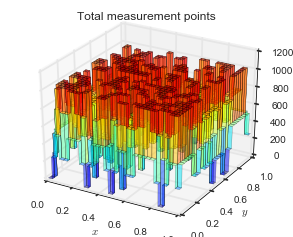

In [10]:
meas_div = 5
m = 2**(meas_div+2) # This is just an amount that relates to the grid size...
vn_div = 3

num_bases = 10
# V_n is the FEM solution approximation space, of dimension n (=2^vn_div * 2^vn_div)
V_n = df.make_hat_basis(vn_div, space='H1')

np.random.seed(5)
condition_nums = np.zeros([7, num_bases])
diffs = np.zeros([7, num_bases])
ms = [int(2**(meas_div+1+mp/2)) for mp in range(1,8)]
for i,m in enumerate(ms):
    print('Dimensions of W = m = {0}, dimension of V_n = n = {1}'.format(m, V_n.n))
    for s in range(num_bases):
        # W is our measurement space, of dimension m
        W = df.make_random_local_integration_basis(m, div=meas_div, width=2, space='H1')

        W_ortho = W.orthonormalise()
        w = W_ortho.dot(fem.u)
        
        u_star, v_star, w_recon, v_proj, cond = df.optimal_reconstruction(W_ortho, V_n, w, disp_cond=True)
        condition_nums[i, s] = cond
        #diffs[i,s] = (u_star - fem.u).norm(space='H1')
    
    # just for illustration we show what one of the measurement bases looks like
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(1,1,1, projection='3d')
    (W.reconstruct(np.ones(W.n))).plot(ax, title='Total measurement points')
    plt.show()
    
    

In [ ]:
plt.loglog(ms, condition_nums.mean(axis=1))
plt.show()